# Optimizing Baseline Cuts

Optimizing the baseline cuts and checking the results on two parameters :
- Percent of Events that Survive
- Accuracy

In [1]:
import ROOT
from ROOT import TLorentzVector
from math import sqrt
import h5py
import numpy as np
import awkward as ak
import pandas as pd
import json
import tensorflow as tf

Welcome to JupyROOT 6.24/00


## Benchmark

Analyzing the accuracy and survial percentage of baseline cuts to get a benchmark of the goal to beat

In [2]:
def getArraysFromFile(inputFile : str, debug = True):
    '''
    Accessor function that gives back lists from hdf5 file. Due to the various conversions from 
    List --> Awkward --> HDF5 file, this function is made as to make the conversion back to list 
    simple.
    Parameters :
    ------------
    inputFile : str, required
        The hdf5 file with the converted list
    Returns :
    ---------
    particleArray : list
        The list that contains the 4-momenta of every particle in every event.
    azArray : list
        The list that contains the azimuthal angle of every particle in every event.
    '''
    if debug:
        print("INFO : Started Getting Data From File")

    hf = h5py.File(inputFile,'r')
    partArray = hf.get("ParticleArray")
    azimuthalArray = hf.get("AzimuthalAngle")
    etaArray = hf.get("EtaAngle")
    phiArray = hf.get("PhiAngle")

    reconstitutedPartArray = ak.from_buffers(
        ak.forms.Form.fromjson(partArray.attrs["form"]),
        json.loads(partArray.attrs["length"]),
        {k: np.asarray(v) for k, v in partArray.items()},
    )

    reconstitutedAzAngle = ak.from_buffers(
        ak.forms.Form.fromjson(azimuthalArray.attrs["form"]),
        json.loads(azimuthalArray.attrs["length"]),
        {k: np.asarray(v) for k, v in azimuthalArray.items()},
    )

    reconstitutedEtaAngle = ak.from_buffers(
        ak.forms.Form.fromjson(etaArray.attrs["form"]),
        json.loads(etaArray.attrs["length"]),
        {k: np.asarray(v) for k, v in etaArray.items()},
    )

    reconstitutedPhiAngle = ak.from_buffers(
        ak.forms.Form.fromjson(phiArray.attrs["form"]),
        json.loads(phiArray.attrs["length"]),
        {k: np.asarray(v) for k, v in phiArray.items()},
    )
    
    particleArray = ak.to_list(reconstitutedPartArray)
    azArray = ak.to_list(reconstitutedAzAngle)
    etaArray = ak.to_list(reconstitutedEtaAngle)
    phiArray = ak.to_list(reconstitutedPhiAngle)

    if debug:
        print("INFO : Done Getting Data from File")
    return particleArray,azArray,etaArray,phiArray

In [3]:
process  = ['ttbar','llbj','tWj','ttV','ttbarh','taubb','hh']
total_events = 0
hh_events = 0

for proc in process:
    if proc != 'hh':
        part,_,_,_ = getArraysFromFile('../../datasets/baseline/' + proc + '_100k.h5',debug=False)
        total_events += len(part)

    if proc == 'hh':
        part,_,_,_ = getArraysFromFile('../../datasets/baseline/' + proc + '_1M.h5',debug=False)
        total_events += len(part)
        hh_events = len(part)

In [5]:
print('Accuracy : ',hh_events/total_events)
print('Survival Rate : ',total_events/(1e6*len(process)))

Accuracy :  0.9807521468759254
Survival Rate :  0.0004824285714285714


## Getting Data

In [6]:
class get_features():
    def __init__(self, procname = 'hh', file_location = '~/Tests/bbWW/', num_events = '100k'):
        self.procname = procname
        self.filepath = file_location + procname + '_' + num_events + '.h5'
        self.part = []
        self.eta = []
        self.phi = []
        self.angle = []

    def get_data(self):
        '''
        Accessor function that gives back lists from hdf5 file. Due to the various conversions from 
        List --> Awkward --> HDF5 file, this function is made as to make the conversion back to list 
        simple.

        Parameters :
        ------------
        None

        Returns :
        ---------
        None
        '''

        print("INFO : Started Getting Data From File")

        hf = h5py.File(self.filepath,'r')
        partArray = hf.get("ParticleArray")
        azimuthalArray = hf.get("AzimuthalAngle")
        etaArray = hf.get("EtaAngle")
        phiArray = hf.get("PhiAngle")

        reconstitutedPartArray = ak.from_buffers(
            ak.forms.Form.fromjson(partArray.attrs["form"]),
            json.loads(partArray.attrs["length"]),
            {k: np.asarray(v) for k, v in partArray.items()},
        )

        reconstitutedAzAngle = ak.from_buffers(
            ak.forms.Form.fromjson(azimuthalArray.attrs["form"]),
            json.loads(azimuthalArray.attrs["length"]),
            {k: np.asarray(v) for k, v in azimuthalArray.items()},
        )

        reconstitutedEtaAngle = ak.from_buffers(
            ak.forms.Form.fromjson(etaArray.attrs["form"]),
            json.loads(etaArray.attrs["length"]),
            {k: np.asarray(v) for k, v in etaArray.items()},
        )

        reconstitutedPhiAngle = ak.from_buffers(
            ak.forms.Form.fromjson(phiArray.attrs["form"]),
            json.loads(phiArray.attrs["length"]),
            {k: np.asarray(v) for k, v in phiArray.items()},
        )

        self.part = ak.to_list(reconstitutedPartArray)
        self.angle = ak.to_list(reconstitutedAzAngle)
        self.eta = ak.to_list(reconstitutedEtaAngle)
        self.phi = ak.to_list(reconstitutedPhiAngle)

        print("INFO : Done Getting Data from File")

    def get_mbb(self):
        mbbTemp = []

        for i in range(len(self.part)):
            ptJetsb = []        # List containing b-tagged Jets
            flag = True         # Flag that True -> Survive the Cut,
                                # False -> Does not Survive the Cut

            for momenta in self.part[i]:
                # Getting a List of Jets to  
                # compute cuts on them
                
                # B-Tagged Jet
                if momenta[2] == 1:
                    ptJetsb.append(momenta[4])
            
            # Record invalid if the two leading momenta are not of b-tagged Jets
            ptJetsb.sort(reverse=True)
            
            # Getting the Index of Leading Jets
            jetIndex = []

            for momenta in self.part[i]:
                for j in range(2):
                    if momenta[2] == 1 and momenta[4] == ptJetsb[j]:
                        jetIndex.append(self.part[i].index(momenta))

            Jet1 = TLorentzVector()
            Jet2 = TLorentzVector()
            
            Jet1.SetPtEtaPhiM(self.part[i][jetIndex[0]][4],
                              self.eta[i][jetIndex[0]],
                              self.phi[i][jetIndex[0]],
                              self.part[i][jetIndex[0]][-1])
            
            Jet2.SetPtEtaPhiM(self.part[i][jetIndex[1]][4],
                              self.eta[i][jetIndex[1]],
                              self.phi[i][jetIndex[1]],
                              self.part[i][jetIndex[1]][-1])
            
            mbbTemp.append((Jet1 + Jet2).M())
        return mbbTemp

    def get_mll(self):
        mllTemp = []
    
        for i in range(len(self.part)):
            leptonIndex = []
            for momenta in self.part[i]:
                if momenta[1] != 0:
                        leptonIndex.append(self.part[i].index(momenta))
                
            for j in range(len(leptonIndex)):
                for k in range(j+1,len(leptonIndex)):
                        
                    Lepton1 = TLorentzVector()
                    Lepton2 = TLorentzVector()
    
                    Lepton1.SetPtEtaPhiM(self.part[i][leptonIndex[j]][4],
                                      self.eta[i][leptonIndex[j]],
                                      self.phi[i][leptonIndex[j]],
                                      self.part[i][leptonIndex[j]][-1])
                                      
                    Lepton2.SetPtEtaPhiM(self.part[i][leptonIndex[k]][4],
                                      self.eta[i][leptonIndex[k]],
                                      self.phi[i][leptonIndex[k]],
                                      self.part[i][leptonIndex[k]][-1])
                    
                    mllTemp.append((Lepton1 + Lepton2).M())
        
        return mllTemp

    def get_rbb(self):
        rbbTemp = []

        for i in range(len(self.part)):
            ptJetsb = []        # List containing b-tagged Jets
            flag = True         # Flag that True -> Survive the Cut,
                                # False -> Does not Survive the Cut

            for momenta in self.part[i]:
                # Getting a List of Jets to  
                # compute cuts on them
                
                # B-Tagged Jet
                if momenta[2] == 1:
                    ptJetsb.append(momenta[4])
            
            # Record invalid if the two leading momenta are not of b-tagged Jets
            ptJetsb.sort(reverse=True)

            # Getting the Index of Leading Jets
            jetIndex = []

            for momenta in self.part[i]:
                for j in range(2):
                    if momenta[2] == 1 and momenta[4] == ptJetsb[j]:
                        jetIndex.append(self.part[i].index(momenta))

            rbbTemp.append(self.angle[i][jetIndex[0]][jetIndex[1]])

        return rbbTemp

    def get_rll(self):
        rllTemp = []
    
        for i in range(len(self.part)):
            leptonIndex = []
            for momenta in self.part[i]:
                if momenta[1] != 0:
                        leptonIndex.append(self.part[i].index(momenta))
                
            for j in range(len(leptonIndex)):
                for k in range(j+1,len(leptonIndex)):
                    rllTemp.append(self.angle[i][leptonIndex[j]][leptonIndex[k]])
                          
        return rllTemp

    def get_ptj(self):
        ptjTemp = []

        for i in range(len(self.part)):
            ptJetsb = []        # List containing b-tagged Jets
            ptAllJets = []      # List of all the Jets
            flag = True         # Flag that True -> Survive the Cut,
                                # False -> Does not Survive the Cut

            for momenta in self.part[i]:
                # Getting a List of Jets to  
                # compute cuts on them
                
                # B-Tagged Jet
                if momenta[2] == 1:
                    ptJetsb.append(momenta[4])
            
            # Record invalid if the two leading momenta are not of b-tagged Jets
            ptJetsb.sort(reverse=True)
            ptjTemp.append(ptJetsb[1])

        return ptjTemp

    def get_ptl(self):
        ptlTemp = []
    
        for i in range(len(self.part)):
            leptonpt = []
            for momenta in self.part[i]:
                if momenta[1] != 0:
                        leptonpt.append(momenta[4])
        
            leptonpt.sort(reverse=True)
            ptlTemp.append(leptonpt[1])
                          
        return ptlTemp

## Getting the required variables

The variables that the baseline cuts are applied on are :
- $m_{ll}$
- $m_{bb}$
- $\Delta R_{bb}$
- $\Delta R_{ll}$
- $p_t$

In [6]:
## Hyperparameters

process  = ['ttbar','llbj','tWj','ttV','ttbarh','taubb','hh']
mll = np.array([])
mbb = np.array([])
rbb = np.array([])
rll = np.array([])
ptj = np.array([])
ptl = np.array([])
tag = np.array([])

In [7]:
for proc in process:
    p1 = get_features(procname = proc,file_location = '../../datasets/sanitize/')
    p1.get_data()
    mll = np.append(mll,p1.get_mll())
    mbb = np.append(mbb,p1.get_mbb())
    rll = np.append(rll,p1.get_rll())
    rbb = np.append(rbb,p1.get_mbb())
    ptj = np.append(ptj,p1.get_ptj())
    ptl = np.append(ptl,p1.get_ptl())
    if proc != 'hh':
        tag = np.append(tag,np.zeros(shape=np.array(p1.get_mll()).shape))
    else:
        tag = np.append(tag,np.ones(shape=np.array(p1.get_mll()).shape))

INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File
INFO : Started Getting Data From File
INFO : Done Getting Data from File


In [8]:
print(mll.shape,mbb.shape,rbb.shape,rll.shape,ptj.shape,ptl.shape,tag.shape)

(79289,) (79289,) (79289,) (79289,) (79289,) (79289,) (79289,)


In [9]:
features = np.vstack((mbb,mll,rbb,rll,ptj,ptl,tag))
features.shape

(7, 79289)

In [10]:
df = pd.DataFrame(features.T,columns=['mbb','mll','rbb','rll','ptj','ptl','tag'])

In [11]:
target = df.pop('tag')
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

train_dataset = dataset.shuffle(len(df)).batch(1)

pen shared object file: No such file or directory; LD_LIBRARY_PATH: /home/blizzard/Applications/madGraph/Delphes::/usr/lib
2021-06-15 19:59:23.149832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/blizzard/Applications/madGraph/Delphes::/usr/lib
2021-06-15 19:59:23.149932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/blizzard/Applications/madGraph/Delphes::/usr/lib
2021-06-15 19:59:23.150028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/blizzard/Applications/mad

In [63]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, input_dim=8, activation='tanh'))
model.add(tf.keras.layers.Dense(100, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['acc'])

In [64]:
model = get_compiled_model()
model.fit(train_dataset, epochs=2)

Epoch 1/2
79289/79289 [==============================] - 166s 2ms/step - loss: 0.2925 - binary_accuracy: 0.8906
Epoch 2/2
79289/79289 [==============================] - 166s 2ms/step - loss: 0.2811 - binary_accuracy: 0.8963


In [56]:
test = pd.DataFrame(features.T[:][int(len(features[0])*0.8):],columns=['mbb','mll','rbb','rll','ptj','ptl','tag'])
tar_test = test.pop('tag')
model.evaluate(test.values,tar_test.values)

496/496 [==============================] - 1s 2ms/step - loss: 1.0789 - binary_accuracy: 0.5559


[1.0788803100585938, 0.5558708310127258]

In [65]:
eval = model.predict(df.values)

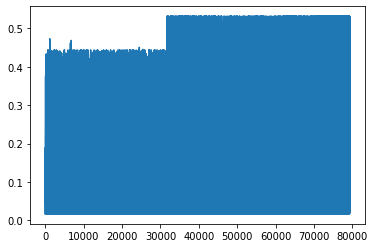

In [66]:
import matplotlib.pyplot as plt
plt.plot(eval)  

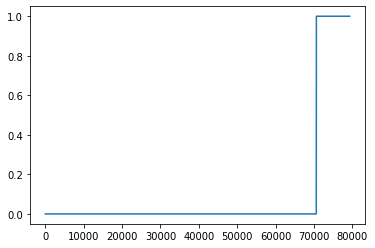

In [31]:
plt.plot(tag)